In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2
from google.colab.patches import cv2_imshow
##lib

In [ ]:
##image reading
inputImg = []
inputImg.append(cv2.imread('./img1.jpg'))
inputImg.append(cv2.imread('./img2.jpg'))
inputImg.append(cv2.imread('./img3.png'))
inputImg.append(cv2.imread('./img4.png'))


In [ ]:
##constract
def powerLaw (img, gamma=1, c=1):
  newImg = np.zeros_like(img)
  newImg = np.array(c*255*(img/255)**gamma, dtype = 'uint8')
  cv2_imshow(newImg)
  print(newImg.shape)
  return newImg

In [ ]:
##color adjust
def colorCorrect (img, gamma=[1,1,1], c=[1,1,1]):
  newImg = np.zeros_like(img)
  for i in range(3):
    newImg[:,:,i] = powerLaw(img[:,:,i], gamma[i], c[i])
  cv2_imshow(newImg)
  return newImg

In [ ]:
##add noise
def addNoise (img, mode, strength):
  inputImg = img/255
  if mode == 'gaussian':
    noise = np.random.normal(0, strength, inputImg.shape)
  elif mode == 'impulse':
    noise = np.random.choice([-2,0,2],inputImg.shape[0:2], p = [strength/2, 1-strength, strength/2])
    if len(inputImg.shape) == 3:
      noise = np.repeat(noise[:,:,np.newaxis], 3, axis=2)
  outputImg = inputImg+noise
  outputImg = np.clip(outputImg,0,1)*255
  cv2_imshow(outputImg)

  return outputImg
##denoising
class filter:
  def __init__(self, array=None, name='', size=None):
    self.array = array
    self.name = name
    self.shape = self.array.shape if size == None else size


def mediumFilter(size = (3,3)):
  return filter(name = 'Medium', size = size)

def adaptiveFilter(size = (3,3)):
  return filter(name = 'Adaptive', size = size)

def adaptiveMedianFilter(size = (3,3)):
  return filter(name = 'Adaptive Medium', size = size)


In [ ]:
def convolution2D (img, kernel):
  ##zero padding
  h = (kernel.shape[0]-1)//2
  w = (kernel.shape[1]-1)//2
  img = np.pad(img, ((h,h),(w,w)), 'constant')
  
  imgHeight, imgWidth = img.shape
  kernelHeight, kernelWidth = kernel.shape
  outImg = np.zeros((imgHeight-kernelHeight+1, imgWidth-kernelWidth+1)).astype(int)
  noiseVar = np.var(img)

  for x in range(imgHeight-kernelHeight+1):
    for y in range(imgWidth-kernelWidth+1):
      if kernel.name == 'Medium':
        outImg[x,y] = np.median(img[x:x+kernelHeight,y:y+kernelWidth])
      elif kernel.name == 'Adaptive':
        tmp = img[x+(kernelHeight-1)//2,y+(kernelHeight-1)//2]
        localVar = np.var(img[x:x+kernelHeight,y:y+kernelWidth])
        if (noiseVar >localVar):
          localVar = noiseVar
        outImg[x,y] = tmp-(noiseVar/localVar)*(tmp-np.mean(img[x:x+kernelHeight,y:y+kernelWidth]))
      elif kernel.name == 'Adaptive Medium':
        tmp = img[x+(kernelHeight-1)//2,y+(kernelWidth-1)//2]
        i = 0
        while(x-i>=0 and x+kernelHeight+i<imgHeight and y-i>=0 and y+kernelWidth+i<imgWidth):
          min = np.min(img[x-i:x+kernelHeight+i,y-i:y+kernelWidth+i])
          max = np.max(img[x-i:x+kernelHeight+i,y-i:y+kernelWidth+i])
          med = np.median(img[x-i:x+kernelHeight+i,y-i:y+kernelWidth+i])

          if(not(min<med and med<max)):
            i+=1
          else:
            if(min<tmp and tmp<max):
              outImg[x,y] = tmp
            else:
              outImg[x,y] = med
            break;
  outImg = np.clip(outImg, 0, 255)
  return outImg

def convolution (img, kernel):
  outImg = np.zeros_like(img)
  imgHeight, imgWidth, imgChannel = img.shape
  for i in range(imgChannel):
    outImg[:,:,i] = convolution2D(img[:,:,i],kernel)
  cv2_imshow(outImg)
  return outImg



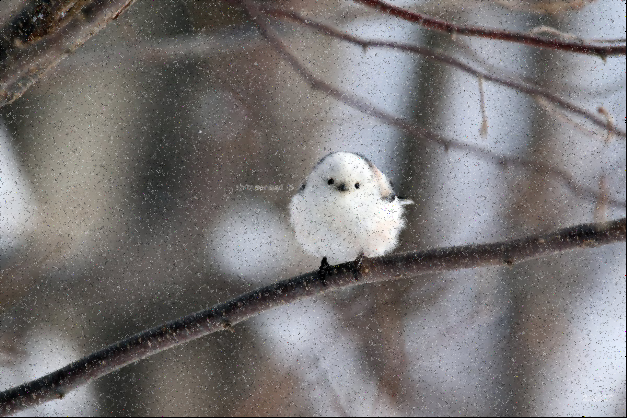

array([[[  0,   0,   0],
        [ 85,  90,  93],
        [ 84,  89,  92],
        ...,
        [113, 104,  99],
        [188, 173, 165],
        [  0,   0,   0]],

       [[ 85,  90,  93],
        [ 86,  91,  94],
        [ 85,  90,  93],
        ...,
        [229, 211, 200],
        [230, 212, 201],
        [  0,   0,   0]],

       [[ 88,  93,  96],
        [ 86,  91,  94],
        [ 87,  93,  96],
        ...,
        [231, 213, 202],
        [231, 213, 202],
        [  0,   0,   0]],

       ...,

       [[ 69,  67,  79],
        [ 72,  71,  82],
        [ 77,  77,  89],
        ...,
        [153, 147, 149],
        [152, 145, 148],
        [  0,   0,   0]],

       [[ 80,  81,  91],
        [ 70,  71,  78],
        [ 90,  92, 101],
        ...,
        [126, 121, 122],
        [154, 147, 150],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

In [ ]:
##use function
convolution (inputImg[3],adaptiveMedianFilter(size = (3,3)))